# K-MEANS CLUSTERING FROM SCRATCH

## INTRODUCTION & OBJECTIVES

IN THIS PROJECT, WE IMPLEMENT THE **K-MEANS CLUSTERING ALGORITHM** ENTIRELY FROM FIRST PRINCIPLES. WE WILL NOT USE `SCIKIT-LEARN` OR ANY BLACK-BOX CLUSTERING UTILITIES. THE GOAL IS TO DEMONSTRATE A DEEP MATHEMATICAL AND ALGORITHMIC UNDERSTANDING OF UNSUPERVISED LEARNING.

### CORE OBJECTIVES
* **MATHEMATICAL RIGOR**: IMPLEMENT EUCLIDEAN, MANHATTAN, AND COSINE DISTANCE METRICS FROM SCRATCH.
* **MODULAR ARCHITECTURE**: DESIGN A ROBUST `KMEANS` CLASS WITH EXPLICIT HYPERPARAMETERS.
* **OPTIMIZATION LOGIC**: IMPLEMENT THE ITERATIVE EXPECTATION-MAXIMIZATION (E-M) LOOP MANUALLY.
* **CONVERGENCE ANALYSIS**: VISUALIZE LOSS CURVES AND CENTROID STABILITY.

### RESTRICTIONS
* **NO SCIKIT-LEARN**.
* **ONLY NUMPY, PANDAS, MATPLOTLIB, SEABORN**.
* **MANUAL SCALING AND CALCULATIONS**.

## IMPORTS & SETUP

### LIBRARIES

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### VISUALIZATION CONFIGURATION

In [3]:
# SETTING GLOBAL PARAMS TO ENSURE ALL PLOTS FOLLOW THE REQUIRED STYLE
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

def enforce_bold_ticks(ax):
    """
    HELPER FUNCTION TO ENSURE TICKS ARE BOLD.
    """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

print("LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.")

LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.


## DATA LOADING AND EXPLORATION

WE LOAD THE `DATA.CSV` FILE CONTAINING OUR 2D DATASET.  
PRELIMINARY VISUALIZATION IS CRUCIAL TO UNDERSTAND THE CLUSTERING TENDENCY OF THE DATA.

In [18]:
# LOAD DATASET
FILE_PATH = 'DATA/DATA.csv'
df = pd.read_csv(FILE_PATH)

In [19]:
# INSPECT DATA STRUCTURE
print("DATA HEAD:")
print(df.head())
print("\nDATA DESCRIPTION:")
print(df.describe())

DATA HEAD:
       x1      x2
0  24.412  32.932
1  35.190  12.189
2  26.288  41.718
3   0.376  15.506
4  26.116   3.963

DATA DESCRIPTION:
              x1         x2
count  60.000000  60.000000
mean   23.568933  23.684633
std    11.203285  13.564296
min    -0.684000   3.412000
25%    19.903750  12.919500
50%    26.202000  19.457500
75%    32.269750  36.312000
max    39.634000  47.693000


In [20]:
# EXTRACT FEATURES AS NUMPY ARRAY
X_raw = df[['x1', 'x2']].values

### VISUALIZE RAW DATA

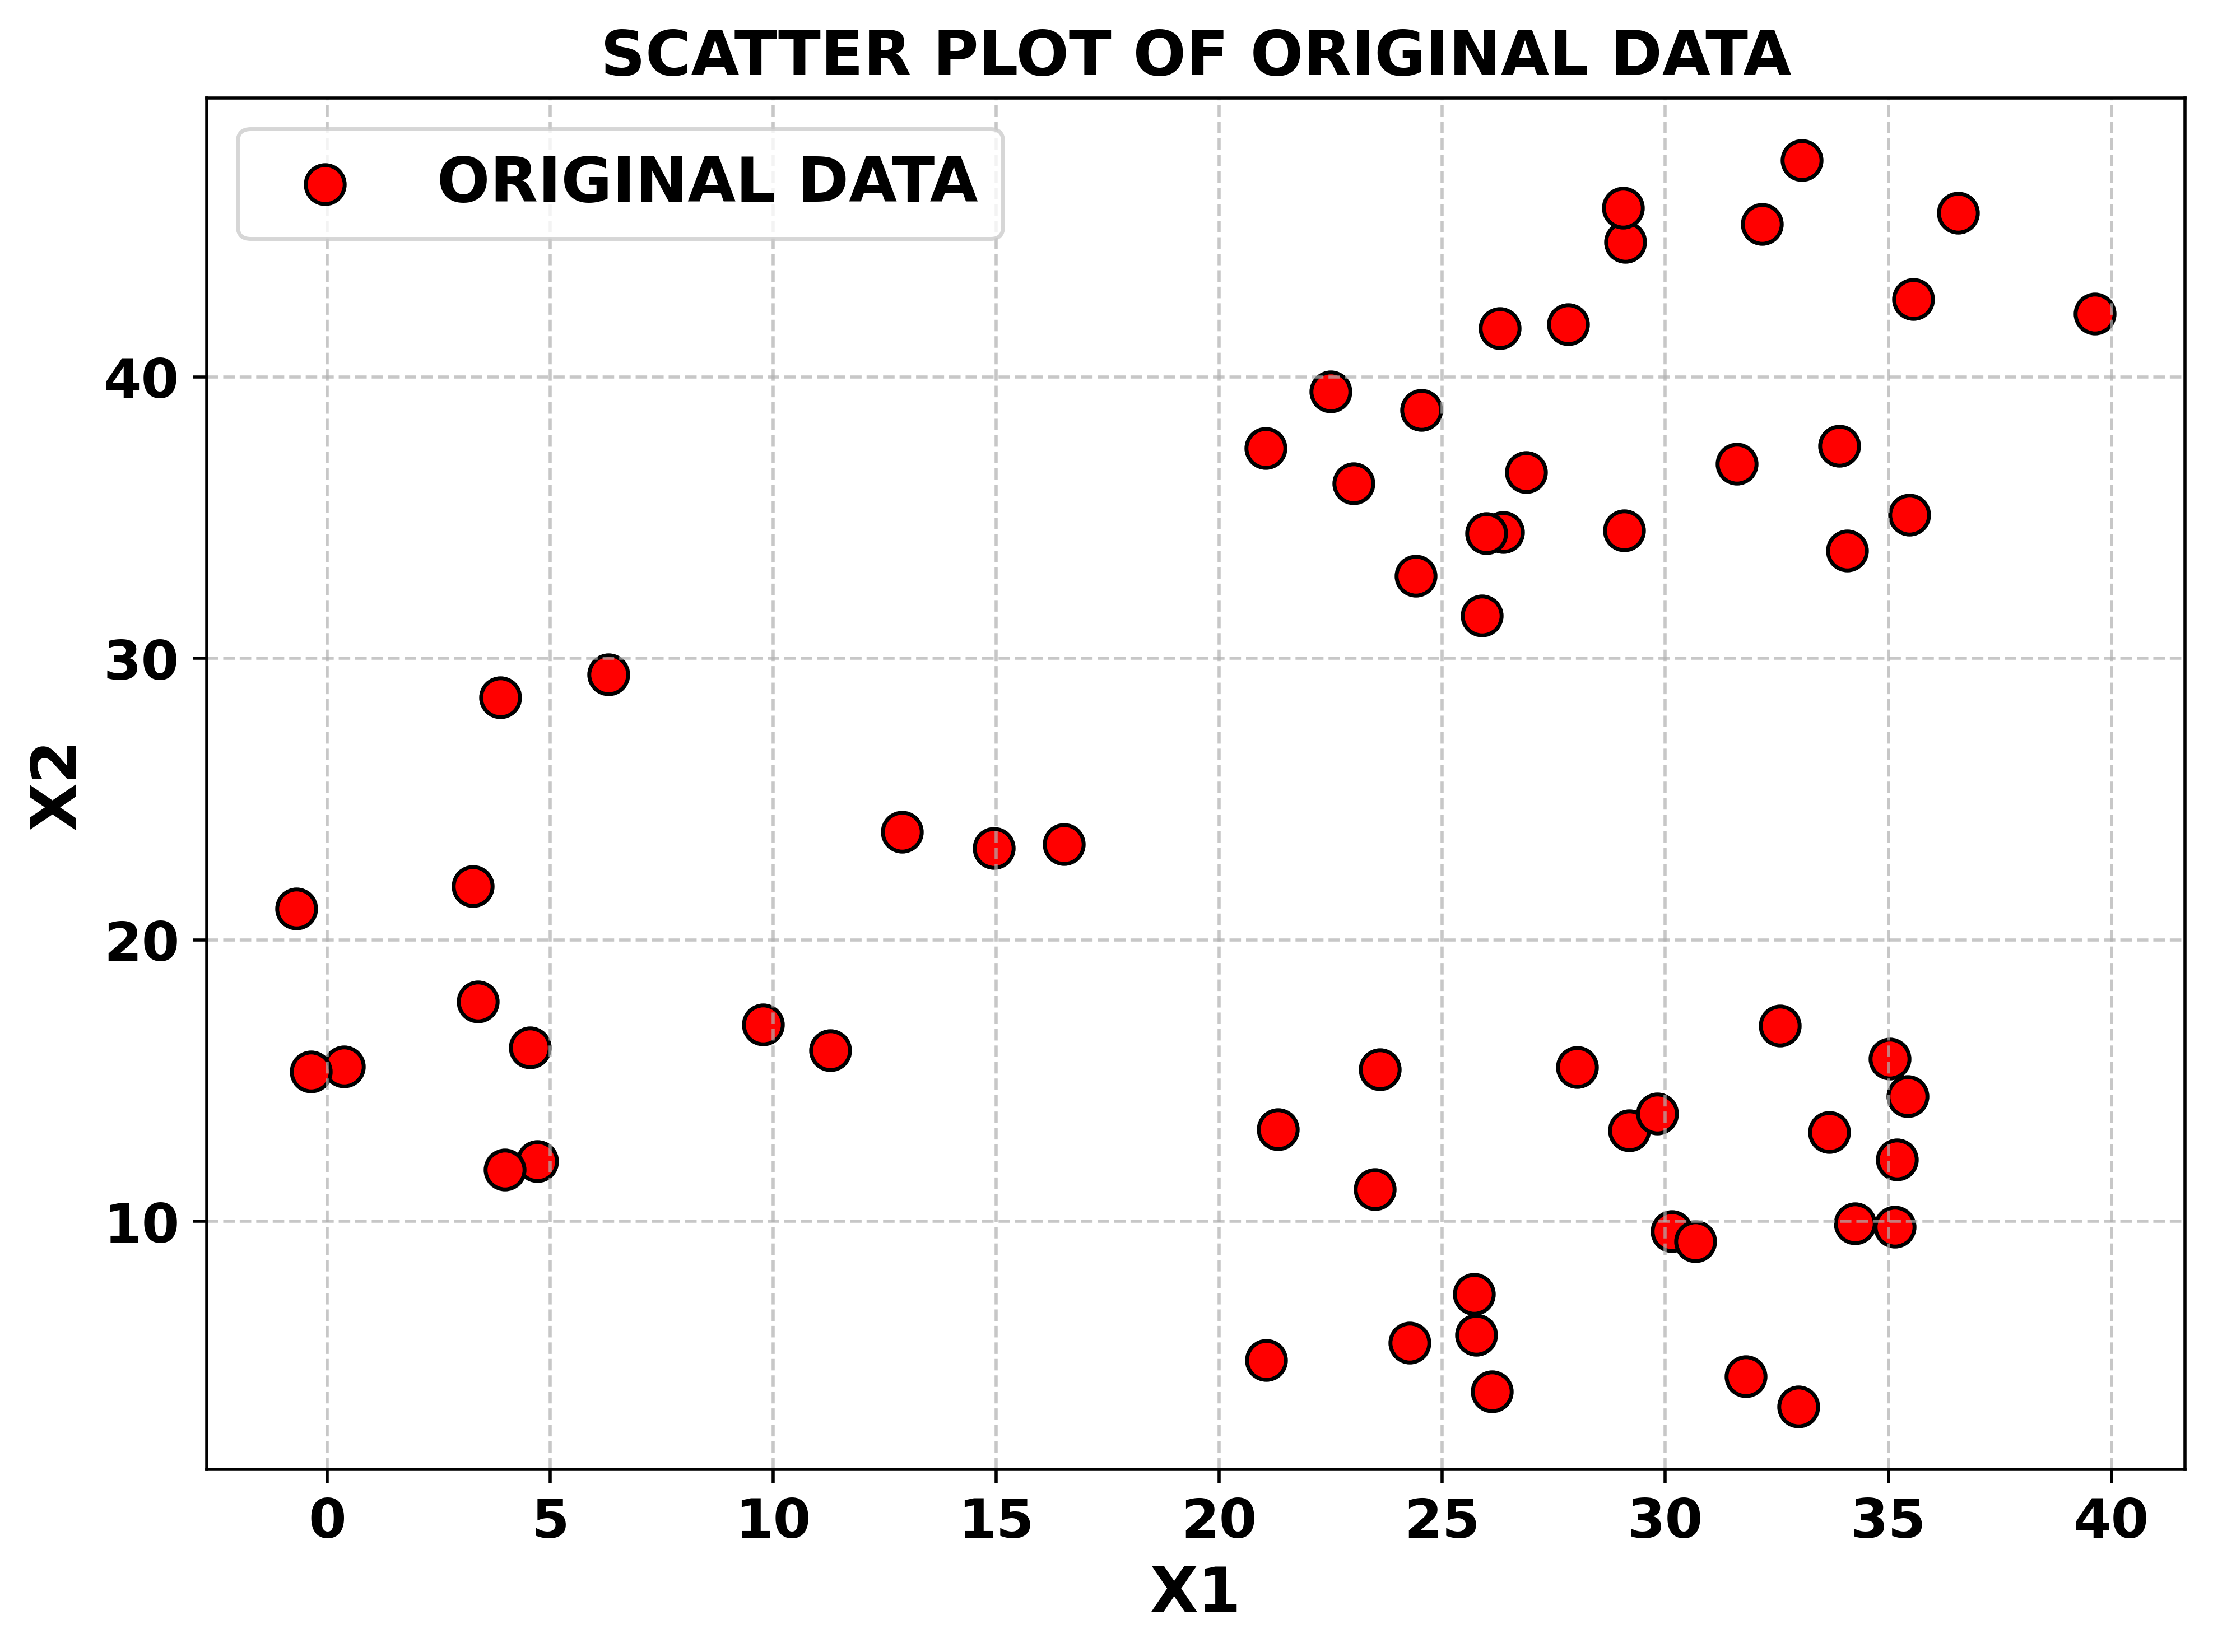

In [21]:
# VISUALIZE ORIGINAL DATA
plt.figure(figsize=(8, 6), dpi=500)
plt.scatter(X_raw[:, 0], X_raw[:, 1], color='red', edgecolor='black', s=100, label="ORIGINAL DATA")

plt.title("SCATTER PLOT OF ORIGINAL DATA")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper left', frameon=True)

enforce_bold_ticks(plt.gca())
plt.tight_layout()
plt.show()

## DATA PREPROCESSING

K-MEANS IS A DISTANCE-BASED ALGORITHM. FEATURES WITH LARGER MAGNITUDES CAN DISPROPORTIONATELY INFLUENCE THE DISTANCE CALCULATIONS. 

TO PREVENT THIS, WE IMPLEMENT **Z-SCORE NORMALIZATION** MANUALLY.

$$x_{scaled} = \frac{x - \mu}{\sigma}$$

WHERE $\mu$ IS THE MEAN AND $\sigma$ IS THE STANDARD DEVIATION.

In [35]:
class StandardScaler:
    """
    IMPLEMENTS Z-SCORE NORMALIZATION.
    """
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        """
        COMPUTES MEAN AND STD, THEN SCALES THE DATA.
        """
        
        # CALCULATE MEAN AND STD ALONG AXIS 0 (COLUMNS)
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0)
        
        # PREVENT DIVISION BY ZERO
        eps = 1e-15
        self.std[self.std < eps] = eps
        
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X_scaled):
        """
        REVERTS SCALING TO ORIGINAL SPACE FOR VISUALIZATION.
        """
        
        return (X_scaled * self.std) + self.mean

In [37]:
# APPLY SCALING

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"RAW DATA MEAN: {np.mean(X_raw, axis=0)}")
print(f"SCALED DATA MEAN (APPROX 0): {np.mean(X_scaled, axis=0)}")
print('-' * 63)
print(f"RAW DATA STD: {np.std(X_raw, axis=0)}")
print(f"SCALED DATA STD (APPROX 1): {np.std(X_scaled, axis=0)}")

RAW DATA MEAN: [23.56893333 23.68463333]
SCALED DATA MEAN (APPROX 0): [-4.81096644e-17  2.16493490e-16]
---------------------------------------------------------------
RAW DATA STD: [11.10953171 13.45078476]
SCALED DATA STD (APPROX 1): [1. 1.]


# WHY Z-SCORE (STANDARDIZATION) INSTEAD OF MIN-MAX SCALING?

IN THIS IMPLEMENTATION, WE CHOSE **Z-SCORE NORMALIZATION** (STANDARDIZATION) OVER **MIN-MAX SCALING**. 

BELOW IS THE MATHEMATICAL AND PRACTICAL JUSTIFICATION FOR THIS DECISION IN THE CONTEXT OF K-MEANS CLUSTERING.

## 1. SENSITIVITY TO OUTLIERS

### THE PROBLEM WITH MIN-MAX
MIN-MAX SCALING TRANSFORMS DATA INTO A BOUNDED RANGE, TYPICALLY $[0, 1]$, USING THE FORMULA:
$$x' = \frac{x - \min(x)}{\max(x) - \min(x)}$$
IF THE DATASET CONTAINS EVEN A SINGLE EXTREME OUTLIER, THE DENOMINATOR $(\max(x) - \min(x))$ BECOMES VERY LARGE. THIS CAUSES THE MAJORITY OF THE "NORMAL" DATA POINTS TO BE SQUASHED INTO A TINY INTERVAL, EFFECTIVELY REMOVING VARIANCE INFORMATION THAT K-MEANS NEEDS TO DISTINGUISH CLUSTERS.

### THE Z-SCORE ADVANTAGE
Z-SCORE SCALING USES MEAN AND STANDARD DEVIATION:
$$z = \frac{x - \mu}{\sigma}$$
WHILE OUTLIERS DO AFFECT THE MEAN AND STANDARD DEVIATION, THEY DO NOT DEFINE THE HARD BOUNDARIES OF THE SCALE. Z-SCORE SCALING IS MORE ROBUST BECAUSE IT SCALES DATA BASED ON THE DISTRIBUTION'S SPREAD (VARIANCE) RATHER THAN ITS ABSOLUTE LIMITS.

## 2. ISOTROPIC VARIANCE ASSUMPTION

K-MEANS (WITH EUCLIDEAN DISTANCE) ASSUMES THAT CLUSTERS ARE SPHERICAL AND HAVE SIMILAR VARIANCE.
* **Z-SCORE** CENTERS THE DATA AT 0 AND SCALES IT TO HAVE UNIT VARIANCE ($\sigma=1$). THIS ALIGNS PERFECTLY WITH THE ALGORITHM'S ASSUMPTION, ENSURING THAT THE DISTANCE METRIC TREATS ALL DIMENSIONS EQUALLY IN TERMS OF STATISTICAL SPREAD.
* **MIN-MAX** DOES NOT GUARANTEE UNIT VARIANCE. ONE FEATURE COULD BE UNIFORMLY DISTRIBUTED OVER $[0,1]$ WHILE ANOTHER IS NORMALLY DISTRIBUTED AND CENTERED AT 0.5 WITH SMALL VARIANCE. K-MEANS MIGHT INCORRECTLY WEIGHT THESE FEATURES.

## 3. HANDLING UNSEEN DATA

IN A PRODUCTION SETTING, WE OFTEN FIT A MODEL ON TRAINING DATA AND PREDICT ON NEW DATA.
* **MIN-MAX SCALING**: IF A NEW DATA POINT FALLS OUTSIDE THE ORIGINAL $[\min, \max]$ RANGE, IT WILL BE SCALED TO A VALUE `< 0` OR `> 1`, POTENTIALLY BREAKING ASSUMPTIONS OR REQUIRING CONSTANT RE-CALCULATION OF BOUNDARIES.
* **Z-SCORE**: NEW DATA SIMPLY DEVIATES MORE FROM THE MEAN (E.G., A Z-SCORE OF 5.0). THIS IS MATHEMATICALLY CONSISTENT AND DOES NOT REQUIRE KNOWING THE ABSOLUTE GLOBAL MINIMUM OR MAXIMUM IN ADVANCE.

## CONCLUSION
WE USE Z-SCORE SCALING BECAUSE IT IS **LESS SENSITIVE TO OUTLIERS** AND **BETTER PRESERVES THE STATISTICAL PROPERTIES** REQUIRED FOR DISTANCE-BASED ALGORITHMS LIKE K-MEANS TO FUNCTION OPTIMALLY.

## MATHEMATICAL FOUNDATION: DISTANCE METRICS

WE DEFINE THE DISTANCE FUNCTIONS $d(p, q)$ THAT WILL DRIVE THE CLUSTERING ASSIGNMENTS.

1.  **EUCLIDEAN DISTANCE ($L_2$)**:
    $$d(p, q) = \sqrt{\sum (p_i - q_i)^2}$$
    *USED FOR SPHERICAL CLUSTERS.*

2.  **MANHATTAN DISTANCE ($L_1$)**:
    $$d(p, q) = \sum |p_i - q_i|$$
    *ROBUST TO OUTLIERS, GRID-LIKE PATHS.*

3.  **COSINE DISTANCE**:
    $$d(p, q) = 1 - \frac{p \cdot q}{||p|| ||q||}$$
    *MEASURES ANGULAR DIFFERENCE RATHER THAN MAGNITUDE.*

## K-MEANS ALGORITHM IMPLEMENTATION

WE CREATE A `KMEANS` CLASS THAT ENCAPSULATES THE ENTIRE LOGIC.

### ALGORITHM STEPS:
1.  **INITIALIZATION**: RANDOMLY SELECT $K$ CENTROIDS.
2.  **ASSIGNMENT**: ASSIGN EACH POINT TO THE NEAREST CENTROID.
3.  **UPDATE**: RECALCULATE CENTROIDS AS THE MEAN OF ASSIGNED POINTS.
4.  **CONVERGENCE**: REPEAT STEPS 2-3 UNTIL CENTROIDS STOP MOVING OR MAX ITERATIONS REACHED.
5.  **COST FUNCTION (INERTIA)**:
    $$J = \sum_{i=1}^{K} \sum_{x \in C_i} ||x - \mu_i||^2$$

In [98]:
class KMeans:
    """
    K-MEANS CLUSTERING IMPLEMENTATION FROM SCRATCH.
    
    ATTRIBUTES:
    -----------
    CENTROIDS : NUMPY ARRAY
        COORDINATES OF CLUSTER CENTERS.
    LABELS : NUMPY ARRAY
        CLUSTER INDEX FOR EACH DATA POINT.
    INERTIA_HISTORY : LIST
        STORES LOSS (WCSS) AT EACH ITERATION.
    FINAL_INERTIA : FLOAT
        FINAL LOSS VALUE AFTER CONVERGENCE.
    ITERATIONS_RUN : INT
        NUMBER OF ITERATIONS EXECUTED.
    """
    def __init__(self, k = 3, max_iter = 100, tol = 1e-4, metric = 'Euclidean', random_state = 36):
        """
        INITIALIZES HYPERPARAMETERS.
        
        ARGS:
        -----
        K : INT
            NUMBER OF CLUSTERS.
        MAX_ITER : INT
            MAXIMUM OPTIMIZATION LOOPS.
        TOL : FLOAT
            CONVERGENCE TOLERANCE (EPSILON).
        METRIC : STR
            DISTANCE METRIC ('EUCLIDEAN', 'MANHATTAN', 'COSINE').
        RANDOM_STATE : INT
            SEED FOR REPRODUCIBILITY.
        """
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.metric = metric
        self.random_state = random_state
        
        self.centroids = None
        self.labels = None
        self.inertia_history = []
        self.final_inertia = None
        self.iterations_run = 0
    
    def initialize_centroids(self, X):
        """
        RANDOMLY SELECTS K DATA POINTS AS INITIAL CENTROIDS.
        """
        
        np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])
        
        return X[indices[:self.k]]
    
    def _euclidean_distance(self, X, centroid):
        """
        EUCLIDEAN DISTANCE: ||x - y||_2
        """
        
        return np.sqrt(np.sum((X - centroid) ** 2, axis = 1))

    def _manhattan_distance(self, X, centroid):
        """
        MANHATTAN DISTANCE: ||x - y||_1
        """
        
        return np.sum(np.abs(X - centroid), axis=1)

    def _cosine_distance(self, X, centroid):
        """
        COSINE DISTANCE = 1 - COSINE SIMILARITY
        """
        
        norm_X = np.linalg.norm(X, axis=1)
        norm_c = np.linalg.norm(centroid)
                
        # AVOID DIVISION BY ZERO
        denominator = norm_X * norm_c
        denominator[denominator == 0] = 1e-15
                
        dot_product = np.dot(X, centroid)
        similarity = dot_product / denominator
        
        return 1 - similarity
    
    def compute_distance(self, X, centroids):
        """
        COMPUTES DISTANCE MATRIX BETWEEN ALL POINTS X AND ALL CENTROIDS.
        RETURNS MATRIX OF SHAPE (N_SAMPLES, K).
        """
        n_samples = X.shape[0]
        n_centroids = centroids.shape[0]
        distances = np.zeros((n_samples, n_centroids))
        
        for i in range(n_centroids):
            centroid = centroids[i]
            
            if self.metric == 'Euclidean':
                # EUCLIDEAN: SQRT OF SUM OF SQUARED DIFFERENCES
                
                dist = self._euclidean_distance(X, centroid)
            
            elif self.metric == 'Manhattan':
                # MANHATTAN: SUM OF ABSOLUTE DIFFERENCES
                
                dist = self._manhattan_distance(X, centroid) 
                
            elif self.metric == 'Cosine':
                # COSINE DISTANCE: 1 - COSINE SIMILARITY
                
                dist = self._manhattan_distance(X, centroid)
            
            else:
                raise ValueError("UNSUPPORTED DISTANCE METRIC")    
                
            distances[:, i] = dist
            
        return distances
    
    def assign_clusters(self, X):
        """
        ASSIGN EACH POINT TO NEAREST CENTROID.
        """
        
        if self.centroids is None:
            raise ValueError("MODEL HAS NOT BEEN FITTED YET!")
        
        distances = self.compute_distance(X, self.centroids)
        labels = np.argmin(distances, axis=1)
            
        return labels

    def update_centroids(self, X):
        """
        UPDATE CENTROIDS AS MEAN OF ASSIGNED POINTS.
        """
        
        new_centroids = np.zeros_like(self.centroids)

        for cluster_idx in range(self.k):
            cluster_points = X[self.labels == cluster_idx]
            
            if len(cluster_points) > 0:
                    new_centroids[cluster_idx] = np.mean(cluster_points, axis=0)
            
            else:
                # HANDLE ORPHAN CENTROIDS BY KEEPING THEM STATIC
                new_centroids[cluster_idx] = self.centroids[cluster_idx]
                
        return new_centroids        
    
    def compute_inertia(self, X, centroids, labels):
        """
        CALCULATES INERTIA (WITHIN-CLUSTER SUM OF SQUARES).
        STRICTLY USES SQUARED EUCLIDEAN DISTANCE FOR COST DEFINITION.
        """
        
        inertia = 0.0
        
        for i in range(self.k):
            cluster_points = X[labels == i]
            
            if len(cluster_points) > 0:
                diff = cluster_points - centroids[i]
                sq_dist = np.sum(diff**2)
                inertia += sq_dist
        
        return inertia
    
    def train(self, X):
        """
        TRAINING LOOP (EXPECTATION-MAXIMIZATION).
        """   
        
        start_time = time.time()                 
        
        # STEP 1: INITIALIZATION
        self.centroids = self.initialize_centroids(X)
        self.inertia_history = []
        
        for i in range(self.max_iter):
            self.iterations_run = i + 1
            
            # STEP 2: ASSIGNMENT (EXPECTATION STEP)
            self.labels = self.assign_clusters(X)
            
            # SAVE OLD CENTROIDS FOR CONVERGENCE CHECK
            old_centroids = self.centroids.copy()
            
            # STEP 3: UPDATE (MAXIMIZATION STEP)
            new_centroids = self.update_centroids(X)
            
            self.centroids = new_centroids
            
            # STEP 4: RECORD LOSS
            current_inertia = self.compute_inertia(X, self.centroids, self.labels)
            self.inertia_history.append(current_inertia)
            
            # STEP 5: CONVERGENCE CHECK
            centroid_shift = np.linalg.norm(self.centroids - old_centroids)
            if centroid_shift < self.tol:
                print(f"CONVERGED AT ITERATION {i+1}")
                break
        
        self.final_inertia = self.inertia_history[-1]   
        self.training_time = time.time() - start_time
        
    def predict(self, X):
        """
        ASSIGN CLUSTERS TO NEW DATA.
        """
        return self.assign_clusters(X)                 

## MODEL TRAINING AND ANALYSIS

WE WILL TRAIN THE MODEL USING $K=3$ AND **EUCLIDEAN DISTANCE**, THEN VISUALIZE THE CLUSTERS AND THE DECISION BOUNDARIES.

In [99]:
# DEFINE HYPERPARAMETERS
K_CLUSTERS = 3
MAX_ITERATIONS = 100
TOLERANCE = 1e-4
METRIC_TYPE = 'Euclidean'
SEED = 36

# INSTANTIATE AND TRAIN
model = KMeans(k=K_CLUSTERS, max_iter=MAX_ITERATIONS, tol=TOLERANCE, metric=METRIC_TYPE, random_state=SEED)

model.train(X_scaled)

CONVERGED AT ITERATION 4


### VISUALIZATION

In [100]:
# PREPARE DATA FOR PLOTTING (INVERSE TRANSFORM)
X_plot = scaler.inverse_transform(X_scaled)
centroids_plot = scaler.inverse_transform(model.centroids)

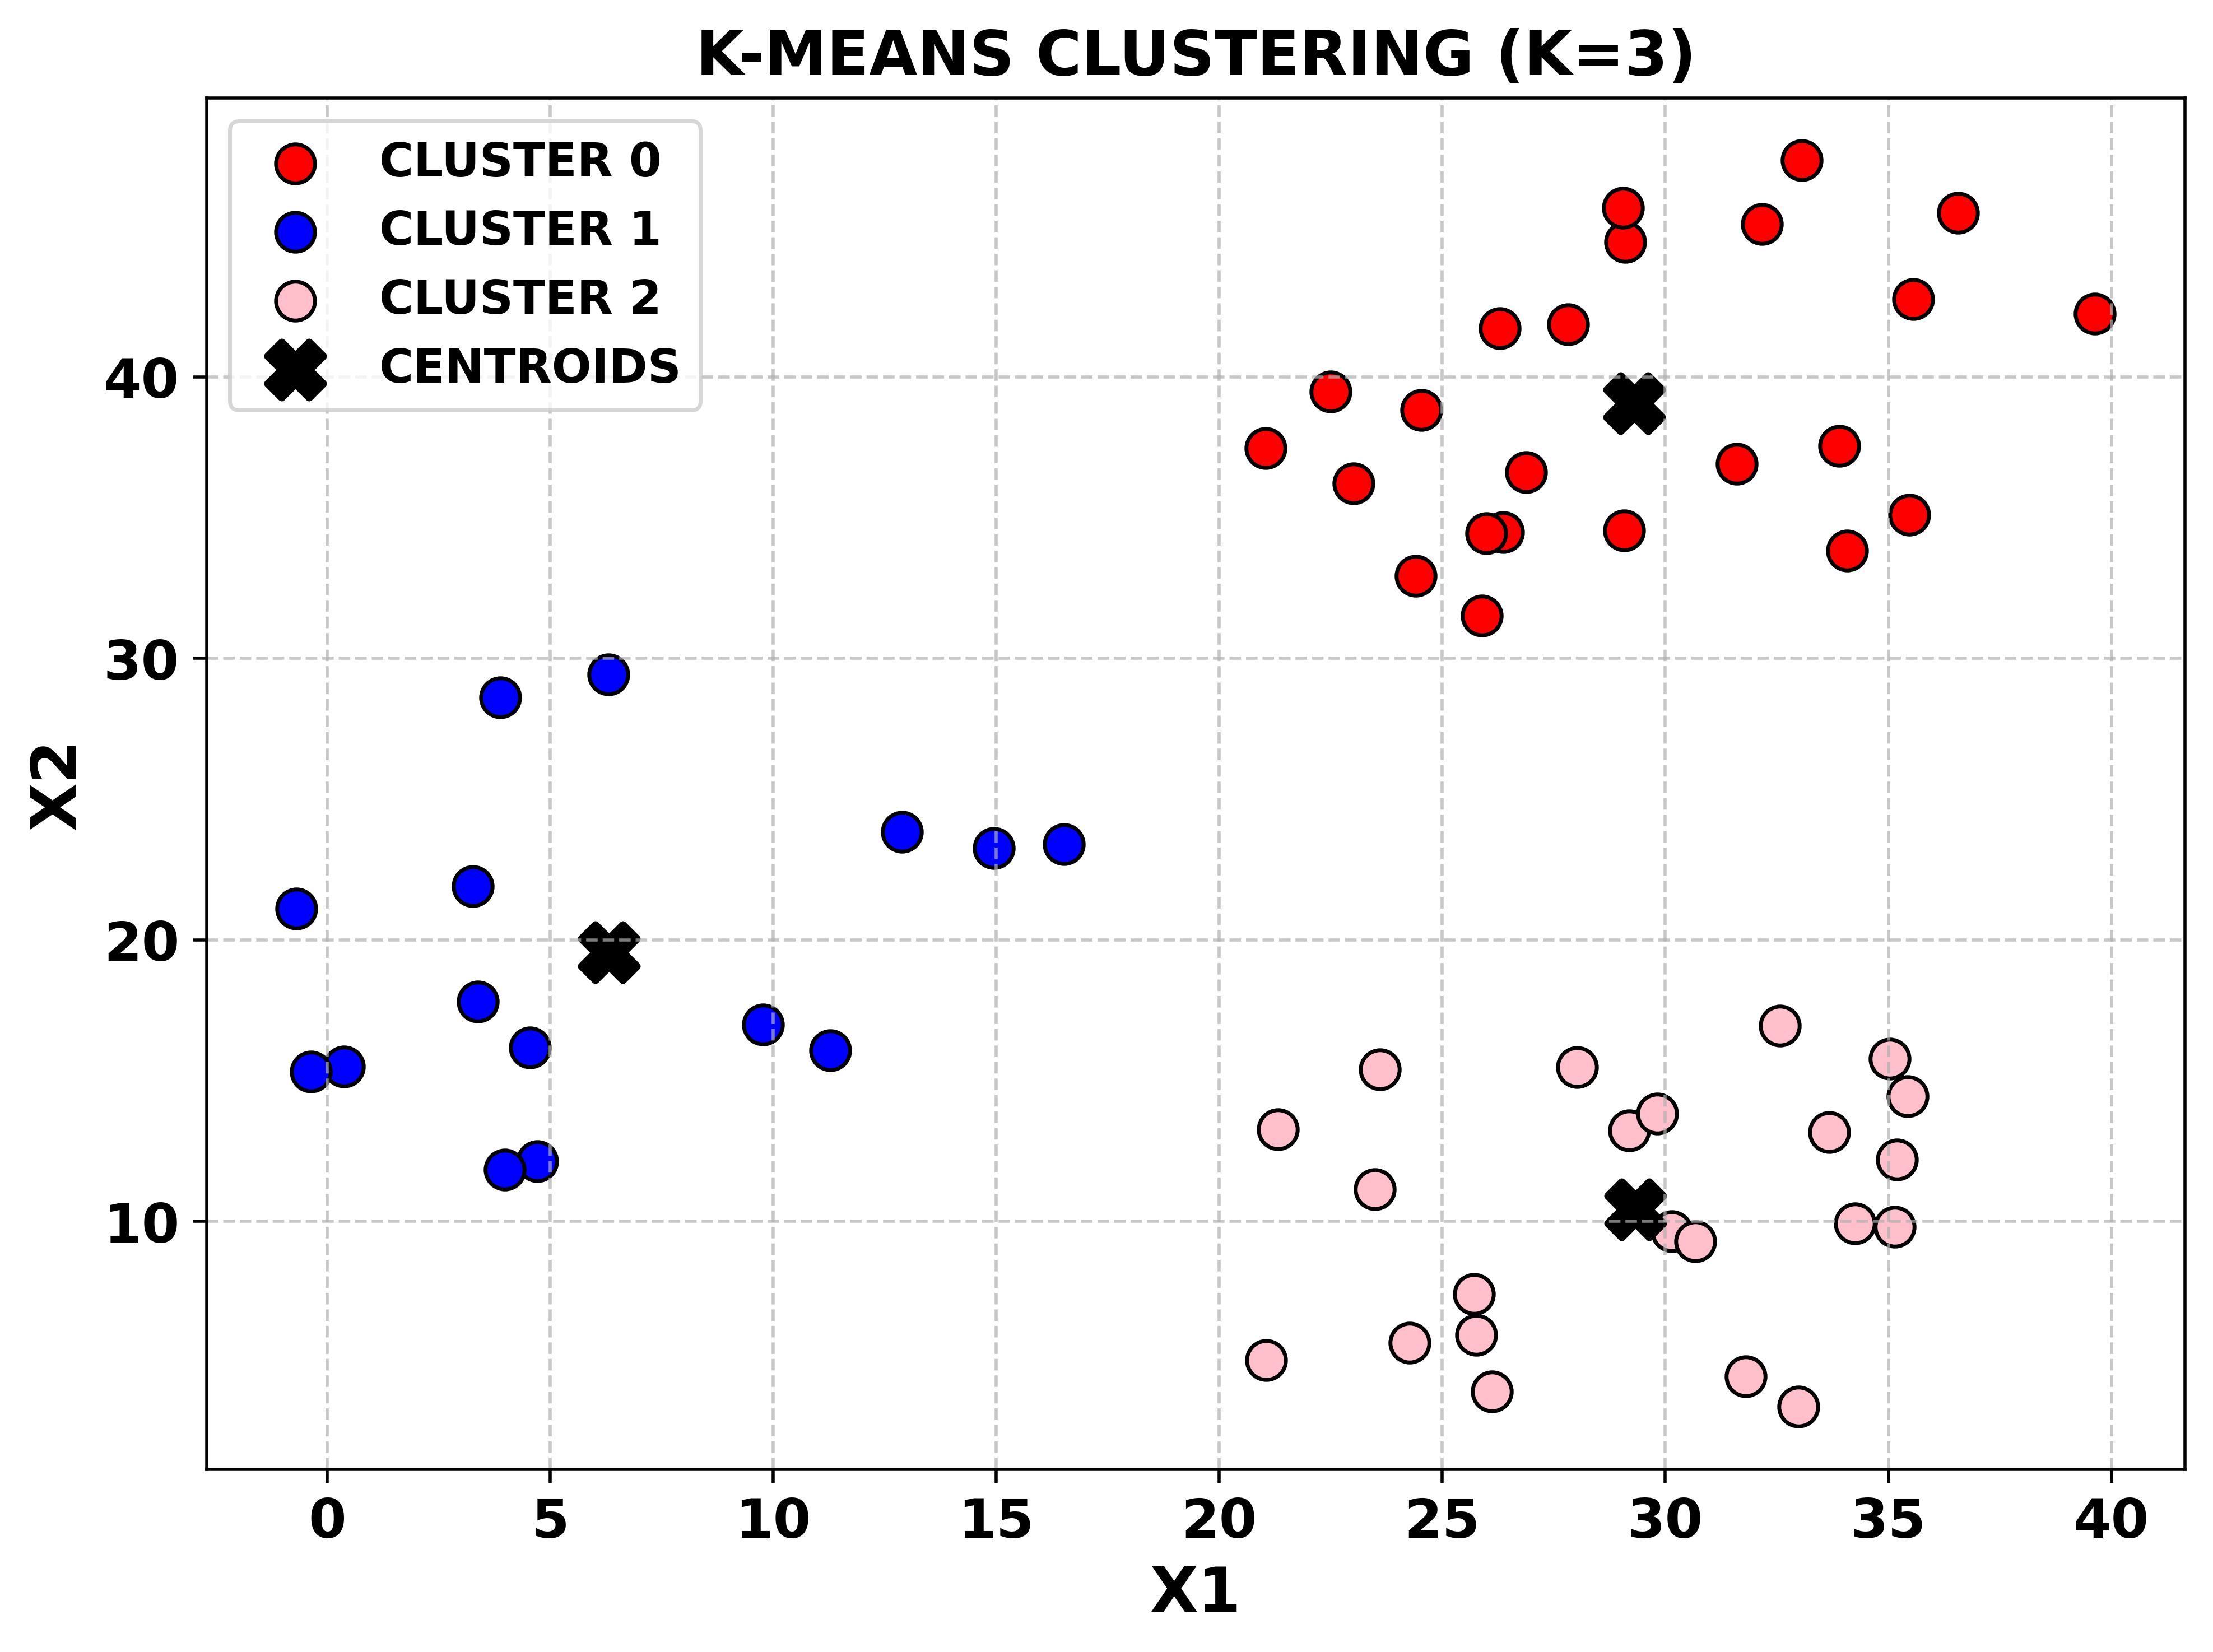

In [101]:
def plot_results(X, labels, centroids, title):
    """
    PLOTS CLUSTERS AND CENTROIDS WITH STRICT STYLING.
    """
    plt.figure(figsize=(8, 6), dpi=500)
    
    # DISTINCT COLORS FOR CLUSTERS
    
    colors = ['red', 'blue', 'pink', 'cyan', 'purple', 'grey', 'gold']
    unique_labels = np.unique(labels)
    
    for i, label in enumerate(unique_labels):
        cluster_data = X[labels == label]
        c = colors[i % len(colors)]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color = c, edgecolor='black', s=100, label=f"CLUSTER {label}")
    
    # PLOT CENTROIDS
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='X', s=200, edgecolor='black', linewidth=2, label="CENTROIDS")
    
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend(loc='upper left', frameon=True, fontsize=12)
    enforce_bold_ticks(plt.gca())
    plt.tight_layout()
    plt.show()

plot_results(X_plot, model.labels, centroids_plot, f"K-MEANS CLUSTERING (K={K_CLUSTERS})")